In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn

import scipy.special
import itertools

# Rule-based model explainability

In this analysis we want to analyse the importance of rules involved in a rule-based model. We base our analysis on a game theory approach, that consists in identifying the marginal contribution of each rule.

$$g(z') = \phi_0 + \sum_{i=1}^M \phi_i z_i'$$

Where $g$ is the explanation model. $z' \in \{0,1\}^M$ is a combination of rules, $M$ is the number of rules, and $\phi_i \in \mathbb{R}$ are the Shapley values (rule importance).

Let us consider a model with 3 rules. All rules are restrictve i.e. the addition of one rule will necessarily filter out more data.

In [2]:
df_data = pd.DataFrame(data={'age':[42,39,45,51],'location':['EU','EU','US','US'],'income':[70,110,80,50]})
df_data.index = ['client1','client2','client3','client4']
df_data

,age,location,income
client1,42,EU,70
client2,39,EU,110
client3,45,US,80
client4,51,US,50


In [3]:
dict_rules = {
    'rule1':'age>40',
    'rule2':'location=="EU"',
    'rule3':'income>60'
}

In [4]:
def scoring_simul(row, activated_rules):
    rules_res = []
    if activated_rules[0]==1:
        age = row['age']
        rules_res.append(eval(dict_rules['rule1']))
    if activated_rules[1]==1:
        location = row['location']
        rules_res.append(eval(dict_rules['rule2']))
    if activated_rules[2]==1:
        income = row['income']
        rules_res.append(eval(dict_rules['rule3']))
    if False not in rules_res:
        return 1
    return 0

Let us now analyse the importance of rule 1 and rule 2. The first intuitive approach consists in removing the rule and seeing the impact on the total proportion.

In [5]:
df_res = df_data.apply(lambda x: scoring_simul(x, activated_rules=[1,1,1]), axis=1)
print('With all rules activated, {}% observation are remaining'.format(df_res.sum()/df_res.shape[0]*100))
df_res

With all rules activated, 25.0% observation are remaining


client1    1
client2    0
client3    0
client4    0
dtype: int64

In [6]:
df_res = df_data.apply(lambda x: scoring_simul(x, activated_rules=[0,1,1]), axis=1)
print('With all rules activated except rule 1, {}% observation are remaining'.format(df_res.sum()/df_res.shape[0]*100))
df_res

With all rules activated except rule 1, 50.0% observation are remaining


client1    1
client2    1
client3    0
client4    0
dtype: int64

In [7]:
df_res = df_data.apply(lambda x: scoring_simul(x, activated_rules=[1,0,1]), axis=1)
print('With all rules activated except rule 2, {}% observation are remaining'.format(df_res.sum()/df_res.shape[0]*100))
df_res

With all rules activated except rule 2, 50.0% observation are remaining


client1    1
client2    0
client3    1
client4    0
dtype: int64

To compare the impact of *rule1* and *rule2* we can't just remove these rules since *rule2* and *rule3* have similar effect on observation 3. Thus, removing *rule1* or *rule2* doesn't make any difference this observation.

<img src='powerset.png' width='220px'></img>

The shap values are a weighted average of the marginal contributions for each combination.

2 approaches can be used to compute the Shapley values.

<ins>Analytical approach</ins> (from the research article): the Shap values are the results of the linear regression $\beta = (X^TWX)^{-1}XWy$ where $W$ is the weighted matrix ("Shapley Kernel"). The weights are computed as such:

$$\omega_{z'} = \frac{M-1}{C^M_{|z'|}|z'|(M-|z'|)}$$

where $z'$ is a coalition.

From https://christophm.github.io/interpretable-ml-book/shap.html#definition:

"The intuition behind it [the weight function] is: We learn most about individual features if we can study their effects in isolation. If a coalition consists of a single feature, we can learn about this feature’s isolated main effect on the prediction. If a coalition consists of all but one feature, we can learn about this feature’s total effect (main effect plus feature interactions). If a coalition consists of half the features, we learn little about an individual feature’s contribution, as there are many possible coalitions with half of the features."

*Note*: the intercept is most probably used because we don't center $X$ (combinations).

<ins>A visual approach</ins> (from the Medium article): the weights are computed looking at the edges of the Powerset.

In [8]:
# Loop on all observations
def predict_proba(activated_rules):
#     activated_rules = activated_rules.tolist()[0]
    label = df_data.apply(lambda x: scoring_simul(x, activated_rules), axis=1).values
    return np.sum(label)/len(label)

In [9]:
# Loop on all possible rule combination
def proba_combinations(activated_rules_arr):
    return np.apply_along_axis(predict_proba, 1, activated_rules_arr)

In [10]:
# Implementation from 
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20Kernel%20SHAP.html

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def shapley_kernel(M,s):
    if s == 0 or s == M:
        return 10000
    return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def kernel_shap(f, x, reference, M):
    X = np.zeros((2**M,M+1))
    X[:,-1] = 1
    weights = np.zeros(2**M)
    V = np.zeros((2**M,M))
    for i in range(2**M):
        V[i,:] = reference

    for i,s in enumerate(powerset(range(M))):
        s = list(s)
        V[i,s] = x[s]
        X[i,s] = 1
        weights[i] = shapley_kernel(M,len(s))
    y = f(V)
    tmp = np.linalg.inv(np.dot(np.dot(X.T, np.diag(weights)), X))
    return np.dot(tmp, np.dot(np.dot(X.T, np.diag(weights)), y)) # Linear regression with kernel (weights)!

In [11]:
M = 3
reference = np.zeros(M)
phi = kernel_shap(proba_combinations, np.array([1,1,1]), reference, M)
shap_values = phi[:-1]

print("shap_values =", shap_values)

shap_values = [-0.25  -0.375 -0.125]


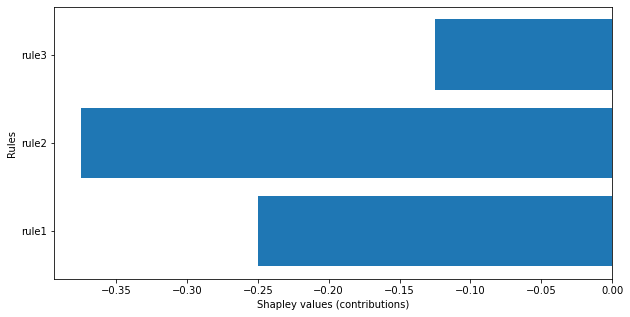

In [27]:
plt.figure(figsize=(10,5))
plt.barh(list(dict_rules.keys()), shap_values)
plt.ylabel('Rules')
plt.xlabel('Shapley values (contributions)')
plt.show()

This result can be easily understood if we look at the other possible combinations involving the two rules. More specifically, we can see that rule 2 si more impactful simply looking at the result with one rule only.

In [12]:
df_res = df_data.apply(lambda x: scoring_simul(x, activated_rules=[1,0,0]), axis=1)
print('With only rule 1 activated, {}% observation are remaining'.format(df_res.sum()/df_res.shape[0]*100))
df_res

With only rule 1 activated, 75.0% observation are remaining


client1    1
client2    0
client3    1
client4    1
dtype: int64

In [13]:
df_res = df_data.apply(lambda x: scoring_simul(x, activated_rules=[0,1,0]), axis=1)
print('With only rule 2 activated, {}% observation are remaining'.format(df_res.sum()/df_res.shape[0]*100))
df_res

With only rule 2 activated, 50.0% observation are remaining


client1    1
client2    1
client3    0
client4    0
dtype: int64